# Test $\Delta$-variance

In [2]:
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
from bokeh.models import LogAxis, Range1d
output_notebook()

from astropy import wcs
from powspec import powspec
from wavan import fan_trans, apodize, padding, depad
from gauss_beam import gauss_beam

Loading BokehJS ...

In [4]:
#Read map
figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/CygnusX-DR21_l081_cdens_cut_nan.fits'
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [5]:
Bwav_k = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_Bwav_k.npy')
BS1a = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_BS1a.npy')
wt1 = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wt.npy')
S11a1 = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S11a.npy')
wav_k1 = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_wav_k.npy')
S1a1 = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_S1a.npy')
q1 = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CygnusX-DR21_l081_q.npy')

Here is the Wavelet and Fourier power spectra. The blue power spectra are corrected for the telescope beam.

In [6]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,1500,1500)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 12. / (60.*reso)  #Beam size at 500 micron
#beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
beam = gauss_beam(FWHM,1500,1500,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
#del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[3]

dFscl = 1400.*np.tan((1./(60.*tab_k))*(np.pi/180.))

#Plot Fourier power spectrum

xmin = 0.1
xmax = 200

Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Scale [arcmin]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log",x_range=(xmin, xmax), tools=Tools)
f.line(1./tab_k, spec_k, color='black', legend='Fourier')
f.line(1./tab_k, spec_k/spec_beamn, legend='Fourier')

#Set a list of q
q=[]
#q[0:4]=[1.4]*5
#q[5:25]=[2.5]*20
q=[2.1]*25
print q

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True)
wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=False, apodize= 0.98, arrdim = np.array([1500,1500]))

#dWscl = 1400.*np.tan((1./(60.*wav_k))*(np.pi/180.))
pcmin = 1400.*np.tan((xmin/60.)*(np.pi/180.))
pcmax = 1400.*np.tan((xmax/60.)*(np.pi/180.))

f.extra_x_ranges = {"parsec": Range1d(start=pcmin, end=pcmax)}
f.add_layout(LogAxis(x_range_name="parsec", axis_label="Scale [pc]"), 'above')

S1an = np.copy(S1a)
S1an[0,3:] = S1a[0,3:]/BS1an[3:]

f.diamond(1./wav_k, S1a[0,:], legend='Wavelet',color='black',line_width=5)
f.diamond(1./wav_k, S1an[0,:], legend='Wavelet',line_width=5)

f.legend.location = "top_left"

showbok(f)

[2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1, 2.1]
1500 1500


Here it is the wavelet power spactrum produced without the normalisation, which allows me to compare the wavelet power spectrum with the Fourier power spectrum.

In [9]:
#Wavelet power spectrum
#wtdv, S11adv, wav_kdv, S1adv, qdv = fan_trans(imzm, reso=reso, q=0, qdyn=False, pownorm=False, apodize= 0.98, arrdim = np.array([1500,1500]))

ko= 5.33
lsq = (ko /(wav_k*reso))**2.

Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Scale [arcmin]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log",x_range=(xmin, xmax), tools=Tools)

f.extra_x_ranges = {"parsec": Range1d(start=pcmin, end=pcmax)}
f.add_layout(LogAxis(x_range_name="parsec", axis_label="Scale [pc]"), 'above')

f.circle(1./wav_k, S1a[0,:]/lsq, legend='Wavelet with beam', color='black',line_width=5)

f.legend.location = "top_left"

showbok(f)

As suspected, this non normalised spectrum is probably equivalent to the $\Delta$-variance spectrum but produced with a different wavelet.

Below is the same non normalised power spectrum corrected for the telescope beam.

In [9]:
#Beam Power spectrum
FWHM = 12. / (60.*reso)  #Beam size
beam = gauss_beam(FWHM,1500,1500,FWHM=True)
#Bwtdv, BS11adv, Bwav_kdv, BS1adv, Bqdv = fan_trans(beam, reso=reso, q=0, qdyn=False, pownorm=True)
#del Bwtdv,BS11adv,Bqdv
#BS1andv = BS1adv / BS1adv[3]

#Wavelet power spectrum
#wtdv, S11adv, wav_kdv, S1adv, qdv = fan_trans(imzm, reso=reso, q=0, qdyn=False, pownorm=False, apodize= 0.98, arrdim = np.array([1500,1500]))

ko= 5.33
lsq = (ko /(wav_k*reso))**2.
lsqF = (ko /(tab_k*reso))**2.

S1adv = S1a1[0,:]/lsq
S1andv = np.copy(S1adv)
S1andv[3:] = S1adv[3:]/BS1an[3:]

Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Scale [arcmin]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log",x_range=(xmin, xmax), tools=Tools)

f.extra_x_ranges = {"parsec": Range1d(start=pcmin, end=pcmax)}
f.add_layout(LogAxis(x_range_name="parsec", axis_label="Scale [pc]"), 'above')

f.circle(1./wav_k, S1a1[0,:]/lsq, legend='Wavelet with beam', color='black',line_width=5)

f.square(1./wav_k, S1andv, legend='Wavelet divided by beam',line_width=5)
#f.square(1./wav_kdv, BS1andv*lsq,line_width=5)

#Fit
coef,cov = np.polyfit(np.log(1./wav_k[5:21]),np.log(S1andv[5:21]),deg=1,cov=True)
yfit = np.exp(coef[1])*(1./wav_k)**coef[0]

print "Power law Gaussian = ", coef[0], np.sqrt(np.diag(cov))

f.line(1./wav_k, yfit, legend='Fit', line_dash='dashed')

f.legend.location = "bottom_right"

showbok(f)

Power law Gaussian =  0.474536615667 [ 0.03635618  0.07124811]


In [14]:
#Beam Power spectrum
FWHM = 12. / (60.*reso)  #Beam size
beam = gauss_beam(FWHM,1500,1500,FWHM=True)
#Bwtdv, BS11adv, Bwav_kdv, BS1adv, Bqdv = fan_trans(beam, reso=reso, q=0, qdyn=False, pownorm=True)
#del Bwtdv,BS11adv,Bqdv
#BS1andv = BS1adv / BS1adv[3]

#Wavelet power spectrum
#wtdv, S11adv, wav_kdv, S1adv, qdv = fan_trans(imzm, reso=reso, q=0, qdyn=False, pownorm=False, apodize= 0.98, arrdim = np.array([1500,1500]))

#lsq = (ko /(wav_kdv*reso))**2.
lsqF = (ko /(tab_k*reso))**2.

S1adv = S1a[0,:]/lsq
S1andv = np.copy(S1adv)
S1andv[3:] = S1adv[3:]/BS1an[3:]

Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="Scale [arcmin]", x_axis_type="log", \
           y_axis_label="variance", y_axis_type="log",x_range=(xmin, xmax), tools=Tools)

f.extra_x_ranges = {"parsec": Range1d(start=pcmin, end=pcmax)}
f.add_layout(LogAxis(x_range_name="parsec", axis_label="Scale [pc]"), 'above')

#f.line(1./tab_k, spec_k/lsqF, color='black', legend='Fourier')
f.circle(1./wav_k, S1a[0,:]/lsq, legend='Wavelet with beam', color='black',line_width=5)

f.square(1./wav_k, S1andv, legend='Wavelet divided by beam',line_width=5)
#f.square(1./wav_kdv, BS1andv*lsq,line_width=5)

#Fit
coef,cov = np.polyfit(np.log(1./wav_k[5:21]),np.log(S1andv[5:21]),deg=1,cov=True)
yfit = np.exp(coef[1])*(1./wav_k)**coef[0]

print "Power law Gaussian = ", coef[0], np.sqrt(np.diag(cov))

#f.line(1./wav_k, yfit, legend='Fit', line_dash='dashed')

f.legend.location = "bottom_right"

showbok(f)

Power law Gaussian =  -0.20362593771 [ 0.05302174  0.10390803]


## Simulation

Calculation of the $\Delta$-variance spectrum (in this case it is the non normalised complex wavelet power spectrum) on a fBm without any beam.

In [36]:
from noisegen import fbm2d

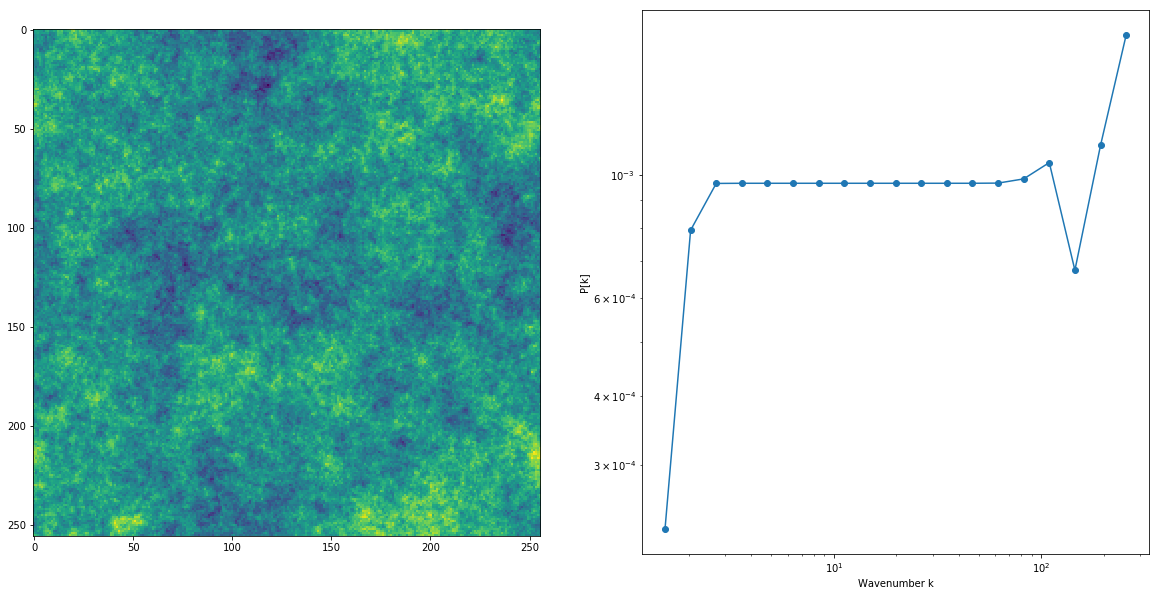

In [37]:
fbm = fbm2d(-2.,256,256)

wtf, S11af, wav_kf, S1af, qf = fan_trans(fbm, reso=1, q=0, qdyn=False, pownorm=False)

figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(fbm)

plt.subplot(1,2,2)
plot(1./wav_kf, S1af, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wavenumber k")
plt.ylabel("P[k]")

I convolve a beam to the map. The beam has a FWHM of 2 pixels, which is equivalent to the Ken Marsh maps. ___Do not care for the last points on the right hand side of the spectrum, they represent scale larger than the map___

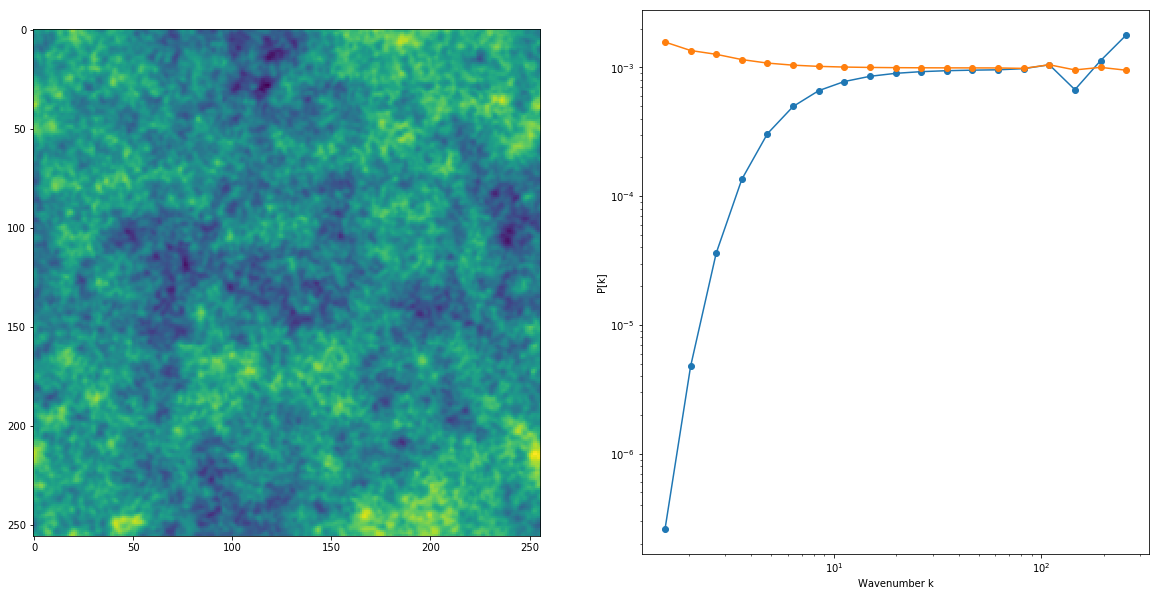

In [47]:
#Convolve a Gaussian beam with FWHM = 2 pixels
fbmB = imsmooth(fbm, 2.0)

wtf, S11af, wav_kf, S1af, qf = fan_trans(fbmB, reso=1, q=0, qdyn=False, pownorm=False)

beam = gauss_beam(2.0,256,256,FWHM=True)
Bwtdv2, BS11adv2, Bwav_kdv2, BS1adv2, Bqdv2 = fan_trans(beam, reso=1, q=0, qdyn=False, pownorm=True)
del Bwtdv2,BS11adv2,Bqdv2
BS1andv2 = BS1adv2 / BS1adv2[3]

lsq = (ko /(wav_kf*reso))**2.
#BS1andv2 = BS1andv2/lsq

figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(fbmB)

plt.subplot(1,2,2)
plot(1./wav_kf, S1af, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wavenumber k")
plt.ylabel("P[k]")

plot(1./wav_kf, S1af/BS1andv2, marker='o')

 Again I calculate the same spectrum on a map without a beam but with point sources with a FWHM of 2 pixels.

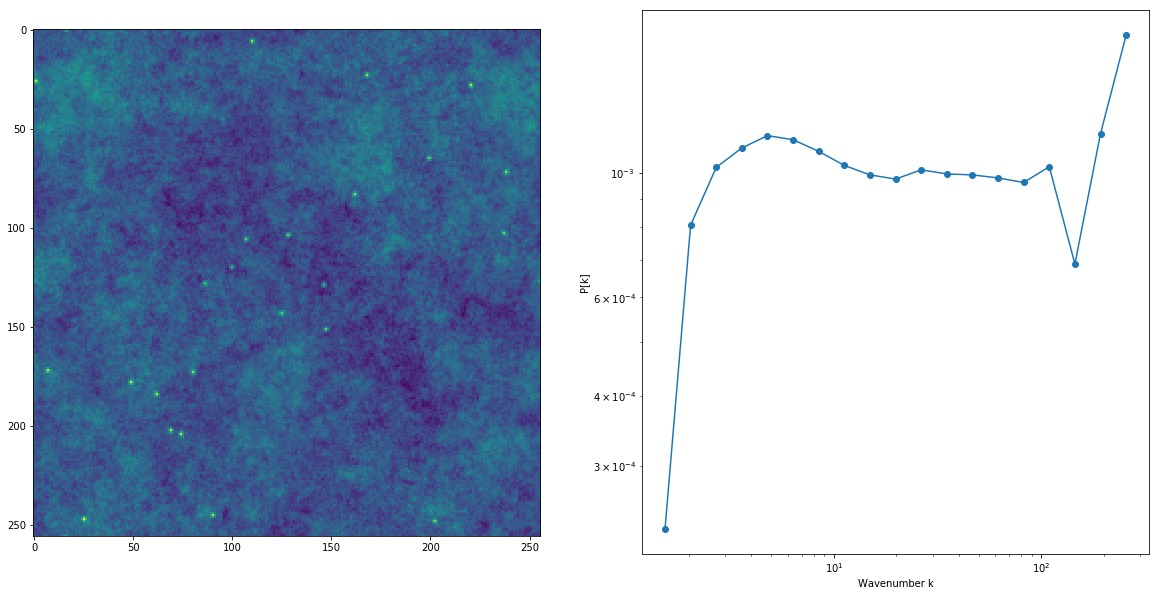

In [98]:
source = gauss_beam(2.0,256,256,FWHM=True) * 8.0

N = 25

smap = np.zeros((256,256))
shift = np.random.uniform(-128,128)
for i in range(N):
    source = np.roll(source,np.int(np.random.uniform(-128,128)), axis=1)
    source = np.roll(source,np.int(np.random.uniform(-128,128)), axis=0)
    smap += source

fbmS = fbm + smap

wtf, S11af, wav_kf, S1af, qf = fan_trans(fbmS, reso=1, q=0, qdyn=False, pownorm=False)

figure(figsize=(20,10))

plt.subplot(1,2,1)
plt.imshow(fbmS)

plt.subplot(1,2,2)
plot(1./wav_kf, S1af, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Wavenumber k")
plt.ylabel("P[k]")